In [1]:
import tensorflow as tf
import os
import os.path as path
import sys
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from struct import unpack


physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) 

ROOT_DIR = path.abspath(path.join(os.getcwd(),".."))
training_data_path = ROOT_DIR + '/data/training/'


all_images = []

directory = os.path.realpath(training_data_path)
for subdir, dirs, files in os.walk(directory):
     for filename in files:
            subdirectoryPath = os.path.relpath(subdir, directory) 
            file1 = os.path.join(directory,subdirectoryPath)
            filePath = os.path.join(file1, filename)
            
            all_images.append(filePath)
            
            try:
                fobj = open(filePath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                os.remove(filePath)                
                print(f'File {filePath} deleted!')
                
                
                
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        


bads = []

for img in tqdm(all_images):
    #image = os.join(root_img,img)
    image = JPEG(img) 
    try:
        image.decode()   
    except:
        bads.append(img)


for name in bads:
    os.remove(name)
    print(f'File: {name} excluded...')
    
    
    

image_size = (256, 256)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_data_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_data_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

class_names = train_ds.class_names
print('Classes Names in the model...')
print(class_names)

Num GPUs Available:  1


100%|██████████| 42603/42603 [02:24<00:00, 295.49it/s]


Found 42603 files belonging to 27 classes.
Using 34083 files for training.
Found 42603 files belonging to 27 classes.
Using 8520 files for validation.
Classes Names in the model...
['bronze', 'ceramic', 'copper', 'earthenware', 'etching', 'faience', 'glass', 'gold', 'graphite', 'ink', 'iron', 'ivory', 'limestone', 'linen', 'marble', 'on_canvas', 'porcelain', 'pottery', 'print', 'salted_paper', 'silk', 'silver', 'steel', 'stone', 'terracotta', 'watercolor', 'wool']


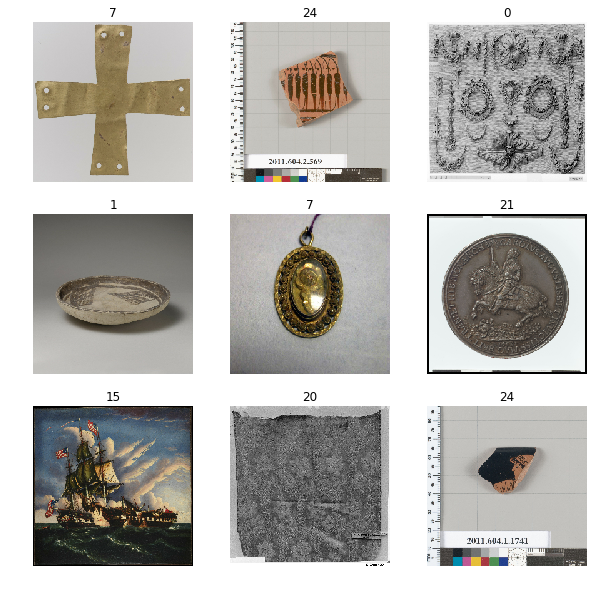

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [3]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

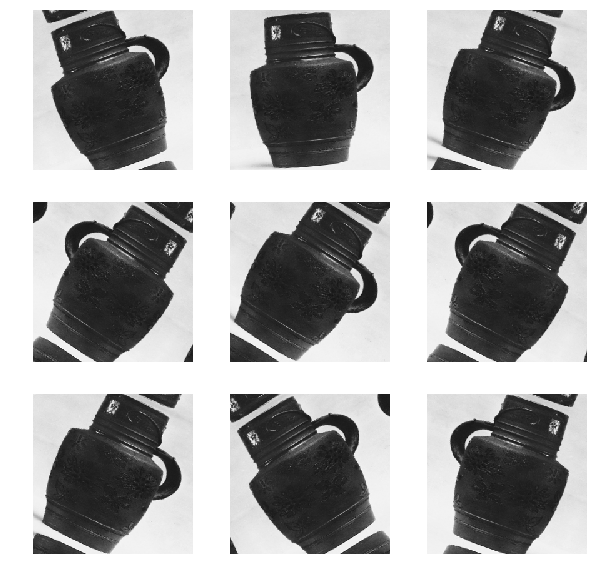

In [4]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [5]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [7]:
input_shape = image_size + (3,)
num_classes = len(class_names)
epochs = 20

inputs = keras.Input(shape=input_shape)
# Image augmentation block
x = data_augmentation(inputs)

# Entry block
x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

previous_block_activation = x  # Set aside residual

for size in [128, 256, 512, 728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

x = layers.SeparableConv2D(1024, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.GlobalAveragePooling2D()(x)
if num_classes == 2:
    activation = "sigmoid"
    units = 1
    loss_function = "binary_crossentropy"
    
else:
    activation = "softmax"
    units = num_classes
    loss_function = "sparse_categorical_crossentropy"

print(f'Num Classes: {num_classes}')
print(f'Num units: {units}')

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(units, activation=activation)(x)

model = keras.Model(inputs, outputs)

model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=loss_function,
    metrics=["accuracy"],
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Num Classes: 27
Num units: 27
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         rescaling[0][0]                  
________________________________________________________________

1066/1066 [==============================] - 1326s 1s/step - loss: 2.3689 - accuracy: 0.3372 - val_loss: 2.1326 - val_accuracy: 0.4081
Epoch 2/20
1066/1066 [==============================] - 1324s 1s/step - loss: 1.6806 - accuracy: 0.5065 - val_loss: 2.0665 - val_accuracy: 0.4026
Epoch 3/20
1066/1066 [==============================] - 1323s 1s/step - loss: 1.4463 - accuracy: 0.5735 - val_loss: 1.6222 - val_accuracy: 0.5397
Epoch 4/20
1066/1066 [==============================] - 1318s 1s/step - loss: 1.2889 - accuracy: 0.6228 - val_loss: 1.6839 - val_accuracy: 0.5425
Epoch 5/20
1066/1066 [==============================] - 1317s 1s/step - loss: 1.1708 - accuracy: 0.6504 - val_loss: 1.3584 - val_accuracy: 0.6023
Epoch 6/20
1066/1066 [==============================] - 1317s 1s/step - loss: 1.0817 - accuracy: 0.6770 - val_loss: 1.3545 - val_accuracy: 0.6150
Epoch 7/20
1066/1066 [==============================] - 1322s 1s/step - loss: 1.0046 - accuracy: 0.6977 - val_loss: 1.2543 - val_accura

This image most likely belongs to bronze with a 7.54 % confidence.


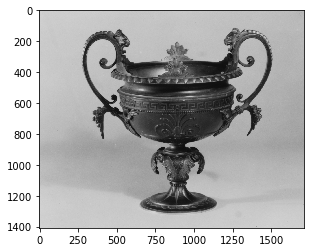

In [6]:
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

model = keras.models.load_model('save_at_5.h5')

def predict(image_path, model=model):

    image_transformed = keras.preprocessing.image.load_img(
        image_path, target_size=(256, 256))
    
    image_array = keras.preprocessing.image.img_to_array(image_transformed)
    image_array_batch = tf.expand_dims(image_array, 0)

    prediction = model.predict(image_array_batch)
    score = tf.nn.softmax(prediction[0])

    print(f"This image most likely belongs to {class_names[np.argmax(score)]} with a {round(100 * np.max(score), 2)} % confidence.")
    
    image_display = mpimg.imread(image_path)
    image_plot = plt.imshow(image_display)
    plt.show()
    
    
image = '/home/studioml/Desktop/github/capivara/data/training/bronze/9168_46165be80d124b958cb054505e93a527_.jpg'

predict(image)